# City of Gothenburg - Purchase analysis

Welcome to the data exploration of the city of Gothenburg. Open data will be analyzed to understand the city of Gothenburg purchasing habits, <b> what </b> it spends money on, <b> whom </b> it buys from and <b> when </b> it happens.

**What is open data?**

> *Open data is information that is available for anyone to use, reuse and share, so that others can develop it and create benefits for more people.* ~ City of Gothenburg Website

   * City of Gothenburg provides access to many open datasets at their website [City of Gothenburg Open Data portal](  https://goteborg.se/wps/portal/start/kommun-o-politik/kommunfakta/stadens-digitala-service/oppna-data)

**Why analyze purchases?**

* City of Gothenburg is a large organization, and spending decisions will impact what services the citizens receive, what suppliers that it supports and ultimately how much taxes that it needs to collect to cover for its purchases.

* High tax revenue only ensures the city has the **opportunity** to make purchases to give the citizens a better life, but its spending decisions determines the actual **outcome** of the goods/services it provides.

**How to analyze purchases?**

* The open data consist of all invoices the city of Gothenburg receives from its suppliers.

* Invoices contains information such as the amount and the account the cost have been booked on, enabling analysis of what types of goods/services that are purchased.

* Since the actual invoicing can differ a bit compared to the purchases orders this exploration does not have ambition to be an exact analysis, but rather act as an exploration for possible interesting perspectives to look at

* The steps of analysis is outlined in the table of contents below


**Table of contents:**
1. [Get the data](#get_the_data)

2. [Purchases through time](#purchases_through_time)

2. [Suppliers of interest](#suppliers_of_interest)

3. [Mixing in Financial Data](#financial_data)





<a id='get_the_data'></a>
## Get the data


**Raw open data**

The open data portal provides information about all the [invoices](https://catalog.goteborg.se/catalog/6/datasets/75) the city of Gothenburg receives from its suppliers. 

* Files is in xlsx format (Excel-file)
* Each file contains transactions for one month
* Data for year 2016-2019 are explored in this analysis

**Data preprocessing**

To be able to analyze all invoices there are two steps needed before it can be loaded as a single Dataframe.

1. Extract information from all xlsx files into a single csv file. 

2. Append data with the year and month the transactions occured in.

The preprocessing steps are outlined in this notebook [will insert link here when done]().

The completed csv file is named 'data.csv' and accessed by this notebook.



In [1]:
import pandas as pd
import functions
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.ticker import MaxNLocator 
import requests
import pickle
from bs4 import BeautifulSoup
df = pd.read_csv('data.csv', low_memory=False)

**Data at a glance**

The data contains the following columns:

* **förvaltning** = What department at the city of Gothenburg that made the purchase
* **leverantör** = Supplier purchased from
* **organisationsnummer** = Organization number, unique identification number for legal entities in Sweden
* **verifikationsnummer** = Voucher number, referencing what voucher in the accounting system the invoice belongs to
* **konto** = Account the cost of the invoice was booked on
* **kontotext** = Account text, describes the purposes of the account 
* **belopp** = Amount for the purchase
* **year** = Year the invoice was booked on
* **month** = Month the invoice was booked on


In [2]:
print('Number of rows in dataset: ' + str(df.shape[0]))
print('Number of unique suppliers: ' + str(len(df['leverantör'].unique())))

Number of rows in dataset: 5738308
Number of unique suppliers: 23991


<a id='purchases_through_time'></a>
## Purchases through time


<font size = 3>
    <i>
        
Exploration starts from a time perspective. Having data for 48 months provides the opportunity to analyze this both from a <b> seasonality </b> and a <b> general trend </b> angle. 
    </i>


**Questions of interest:**

> **Q1:** What is the general trend, are there more purchases in 2019 vs 2016?

> **Q2:** Are there any seasonality, do some months have a higher volume of purchases than others?


**Data-processing**

Data is grouped by the time variables 'year' and 'month'. 


In [3]:
#Group data by year_month
df_time = df.groupby(['year', 'month'])['belopp'].agg(['sum', 'count']).reset_index()

#Extract a new column period and the values and period. 
df_time['period'] = df_time[['year', 'month']].apply(lambda x: '_'.join(x.astype(str)), axis = 1)
values = np.array(df_time['sum'])
idx = np.array(df_time['period'])

**Heatmap**

One way to look at all the purchases is via a heatmap. 

* In this scenario, March and December stands out for having a higher volume than the other months. 

* The reasons for this could be further investigated, one possible explanation is that many suppliers ends there accounting year in December or March so its important for them to send invoices at those months. 

* During the popular vacation period in July there are few invoices, and also January have a lower volume than the average. 


Text(0.5, 1.0, 'Heatmap purchases per year/month')

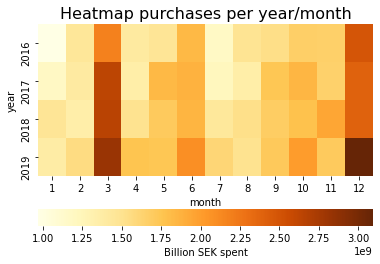

In [4]:
#Adjust data format to fit into seaborn
heatmap_data = pd.pivot_table(df_time[['year', 'month', 'sum']], values = 'sum', index = ['year'], columns = 'month')

#Plot heatmap via seaborn
sns.heatmap(heatmap_data, cmap = 'YlOrBr', cbar_kws={'label': 'Billion SEK spent', 'orientation': 'horizontal'})
plt.title('Heatmap purchases per year/month', fontsize = 16)

**Barchart**

Another way to visualize time series is via a barchart. 

This could also be complemented with a rolling moving average line to a see a more smoother trend.

* There are not a straight line of increasing volume, since a clear sign of seasonality can be seen
* The general trend are that the volume increasing, with purchase volumes being larger in 2019 than in 2016



In [5]:
## Rolling Means

months = 3

# Create a rolling window and calculate the mean. Fill in missing data, e.g the initial months which does not have rolling means and fill them in with the value of the first month that has. 
rolling_windows = df_time['sum'].rolling(months)
rolling_mean = rolling_windows.mean().fillna(df_time['sum'][months])


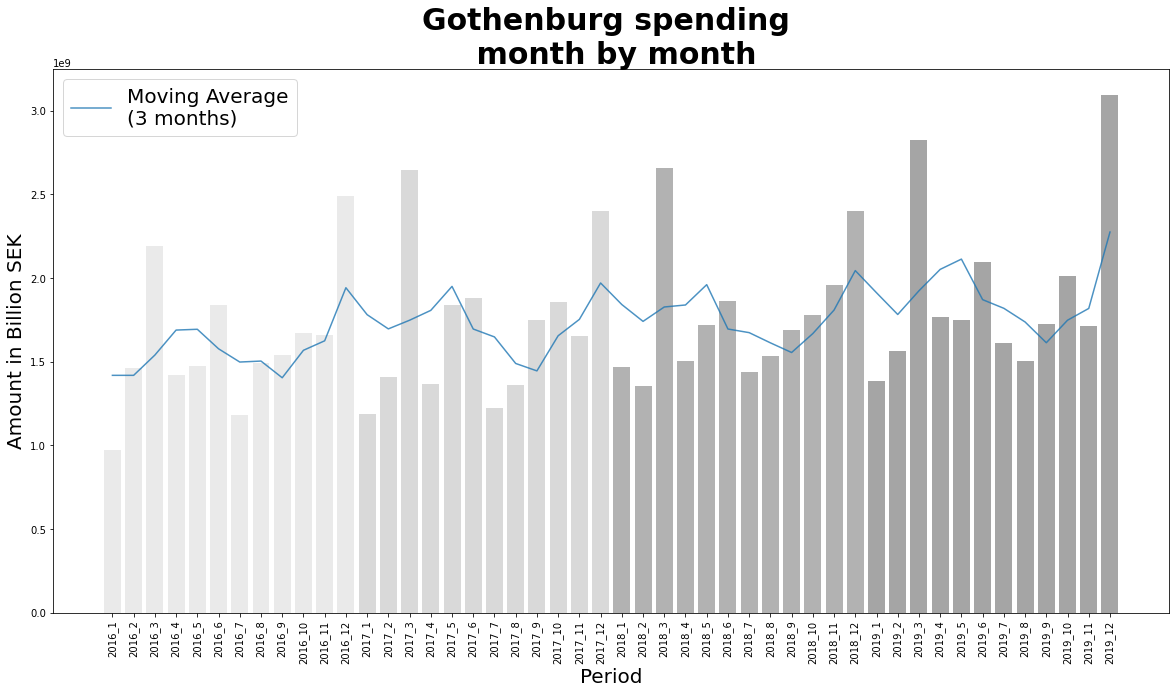

In [6]:
## Plotting

#Color on bar charts, to make the year stand out a little bit
color_list = []

for period in idx:
    year = period[0:4]
    if year == '2016':
        color_list.append('gainsboro')
    elif year == '2017':
        color_list.append('silver')
    elif year == '2018':
        color_list.append('grey')
    else:
        color_list.append('dimgray')

plt.figure(figsize=(20,10))
plt.plot(rolling_mean, alpha = 0.8, label = 'Moving Average' + '\n(' + str(months) + ' months)')
plt.bar(idx,values, color = color_list, alpha = 0.6)
plt.xlabel('Period', fontsize = '20')
plt.xticks(rotation = 90)
plt.ylabel('Amount in Billion SEK', fontsize = '20')
plt.title('Gothenburg spending \n month by month', fontsize = '30', fontweight = 'bold')
plt.legend(loc = 'upper left', fontsize = 20)
plt.show()

**Conditional formatting**

For excel users the conditional formatting is a common tool for displaying values into different categories. 

Same functionality can be used in Python to highlight certain values, in this case the following formatting is applied:

* <p style="color:green">Value below 90% of mean is green</p> 
* <p style="color:red">Value above 110% of mean is red</p> 

There is clear that the months are not symetrical around the mean, there are a few months with very high volumes that impacts the mean. 

In [7]:
cond_high_limit = 110
cond_low_limit = 90
def conditional_formatting(val):
    '''
    Highlight values below cond_low_limit in green, and values above cond_high_lim in red. Return other values as black (default)
    '''
    if isinstance(val,float):
        if val>cond_high_limit:
            color = 'red'
        elif val < cond_low_limit:
            color = 'green'
        else:
            color = 'black'
    else:
        color = 'black'
    return 'color: %s' % color

In [8]:
df_time['percent_average'] = (df_time['sum']/(df_time['sum'].mean()))*100
print('__Sorted by percent average__')
display(df_time[['period', 'percent_average']].sort_values('percent_average').style.applymap(conditional_formatting))
print('__Sorted by date__')
display(df_time[['period', 'percent_average']].style.applymap(conditional_formatting))

__Sorted by percent average__


,period,percent_average
0,2016_1,55.178367
6,2016_7,67.151208
12,2017_1,67.693654
18,2017_7,69.696406
25,2018_2,76.939753
19,2017_8,77.401502
15,2017_4,77.767119
36,2019_1,78.616149
13,2017_2,80.020121
3,2016_4,80.682248


__Sorted by date__


,period,percent_average
0,2016_1,55.178367
1,2016_2,83.042633
2,2016_3,124.508821
3,2016_4,80.682248
4,2016_5,83.861663
5,2016_6,104.611306
6,2016_7,67.151208
7,2016_8,84.852800
8,2016_9,87.578876
9,2016_10,95.166258


<a id='suppliers_of_interest'></a>
## Suppliers of interest


<font size = 3>
    <i>
        
Exploration from a supplier perspective. Having data on 20'000+ unique suppliers, if each supplier would be analyzed for just <b> 5 seconds </b> it would take more than <b> 28 hours </b> to look at them all. Finding the interesting suppliers requires having ways to filter out the ordinary ones. 
    </i>
    
One way would be to follow the famous quote from the financial analysts Martin Zweigs:

> The trend is your friend ~ Martin Zweig

Looking at the trend, interesting suppliers could be filtered out as having an steady **upwards** (receiving more purchases) or **downwards** trend. 
    
> **Q1:** Which companies are having consistently more purchases from the city of Gothenburg over the years?
    
> **Q2:** Are there any explanations why those companies are on this trend?

    
<hr>
    
Another way is to analyze with the basis of the accounts the invoices are booked on. This perspective could bring insights into different industries, what are the major suppliers of certain industries, for example the IT and technical industries.
    
> **Q3:** Which companies are the major suppliers within in the IT and technical industries?


### Trend analysis

**Processing the data**

* Analyzing the trends for suppliers requires some processing of the data, defining some functions to aggregate the data to calculate increasing and decreasing trends.


In [9]:
# Custom built aggregation functions

# Verify if monotonically increasing serie
# requiring specified min amount of years, otherwise set as False.
def increasing(series, x):
    return all(i < j for i,j in zip(series, series[1:])) & (series.size >= x)

# Verify if monotonically decreasing serie
# requiring specified min amount of years, otherwise set as False.
def decreasing(series, x):
    return all(i > j for i,j in zip(series, series[1:])) & (series.size >= x)

# Check difference between first and last element in serie
def total_diff(series):
    sub = series.iloc[-1] - series.iloc[0]
    return sub

# Calculate the mean of the serie and compare the difference with respect to the mean. 
# requiring specified min amount of years, otherwise set as 0. 
def changes_wrt_mean(series, x):
    if(series.size != x):
        return 0
    changes = series.iloc[-1] - series.iloc[0]
    mean = series.mean()
    return 100*changes/mean


In [10]:
#Initial group by supplier and year
df_supp_yy = df.groupby(['leverantör', 'year'])['belopp'].sum().reset_index()

In [11]:
# Grouping with custom built functions
min_years = 4
df_supp = df_supp_yy.groupby(['leverantör'])['belopp'].agg([('increasing_mono',lambda x: increasing(x,min_years)),
                                                         ('decreasing_mono', lambda x: decreasing(x,min_years)),
                                                         'mean',
                                                         ('total_diff', total_diff),
                                                         ('changes_wrt_mean', lambda x: changes_wrt_mean(x,min_years))]).reset_index()

In [12]:
# Display values
pd.options.display.float_format = '{:,.0f}'.format
df_supp.sort_values('changes_wrt_mean', ascending=False)

,leverantör,increasing_mono,decreasing_mono,mean,total_diff,changes_wrt_mean
12889,LINGMERTHS RESEBYRÅ AB,False,False,"3,917,100","15,531,404",397
9624,HÄLSO- OCH SJUKVÅRDSUTSK,False,False,"2,869,177","11,343,700",395
7351,FÖRVALTNINGS AB GÖTEBORGSLOKALER,False,False,"24,224,769","95,414,437",394
10704,JOAB FÖRSÄLJNINGS AB,True,False,"92,637","363,414",392
586,AGERBLOM ÅKERI AB,False,False,"267,469","1,042,657",390
...,...,...,...,...,...,...
4425,DAHLSTRÖMS ENTREPRENAD AB,False,False,"3,236,075","-11,975,801",-370
214,AB GÖTEBORGS FÖRENADE PLÅTSLAGERI,False,False,"235,866","-876,518",-372
1740,ASTAR AB,False,False,"292,546","-1,122,012",-384
20675,SVERIGES KOMMUNER OCH LANDSTING,False,True,"1,558,693","-6,217,337",-399


**Visualizing the trend**

In the graph below there are two plots, one for all suppliers and one which excludes very suppliers with too small volumes.

There are indeed suppliers which has a very strong trend signal, both upwards and downwards. 

* Let's look at some of these in more detail:

    * **MARTIN O SERVERA AB**
    * **CANOS VOB AB**

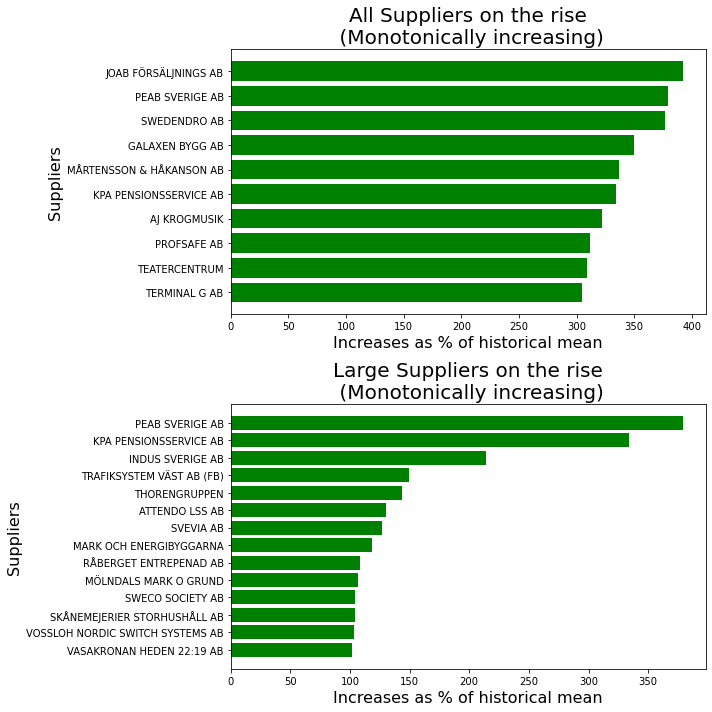

In [13]:
#Create two subplots
fig, ax = plt.subplots(2,1, figsize= (10,10))

#Create barcharts with filtered data
mean_lim = 0
wrt_lim = 300
df_plot = df_supp[(df_supp['mean'] > mean_lim) & (df_supp['changes_wrt_mean'] > wrt_lim) & df_supp['increasing_mono']].sort_values('changes_wrt_mean')
ax[0].barh(df_plot['leverantör'], df_plot['changes_wrt_mean'], color = 'green')
ax[0].set_ylabel('Suppliers', fontsize = 16)
ax[0].set_xlabel('Increases as % of historical mean', fontsize = 16)
ax[0].set_title('All Suppliers on the rise\n (Monotonically increasing)', fontsize = 20)

mean_lim = 10000000
wrt_lim = 100
df_plot = df_supp[(df_supp['mean'] > mean_lim) & (df_supp['changes_wrt_mean'] > wrt_lim) & df_supp['increasing_mono']].sort_values('changes_wrt_mean')
ax[1].barh(df_plot['leverantör'], df_plot['changes_wrt_mean'], color = 'green')
ax[1].set_ylabel('Suppliers', fontsize = 16)
ax[1].set_xlabel('Increases as % of historical mean', fontsize = 16)
ax[1].set_title('Large Suppliers on the rise\n (Monotonically increasing)', fontsize = 20)

plt.tight_layout()

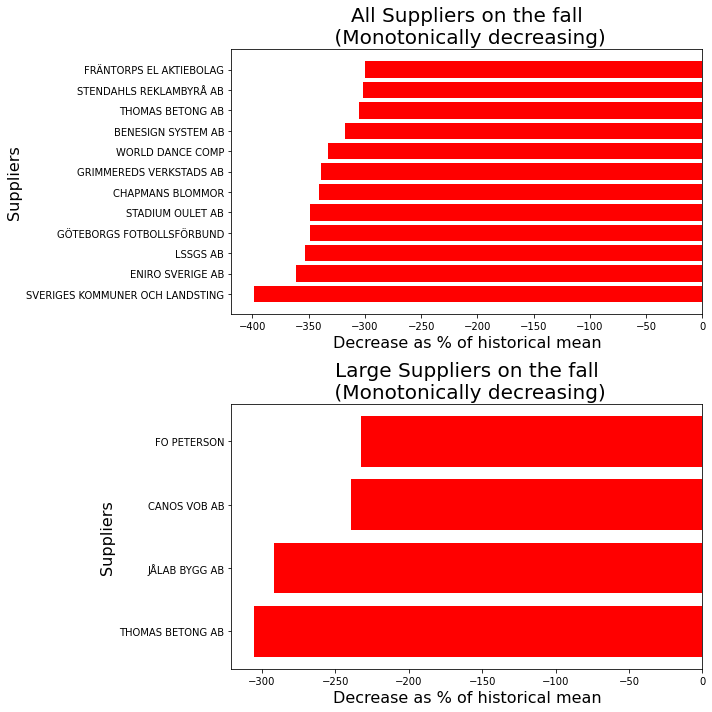

In [14]:
#Create two subplots
fig, ax = plt.subplots(2,1, figsize= (10,10))

#Create barcharts with filtered data
mean_lim = 0
wrt_lim = -300
df_plot = df_supp[(df_supp['mean'] > mean_lim) & (df_supp['changes_wrt_mean'] < wrt_lim) & df_supp['decreasing_mono']].sort_values('changes_wrt_mean')
ax[0].barh(df_plot['leverantör'], df_plot['changes_wrt_mean'], color = 'red')
ax[0].set_ylabel('Suppliers', fontsize = 16)
ax[0].set_xlabel('Decrease as % of historical mean', fontsize = 16)
ax[0].set_title('All Suppliers on the fall\n (Monotonically decreasing)', fontsize = 20)

mean_lim = 10000000
wrt_lim = -200
df_plot = df_supp[(df_supp['mean'] > mean_lim) & (df_supp['changes_wrt_mean'] < wrt_lim) & df_supp['decreasing_mono']].sort_values('changes_wrt_mean')
ax[1].barh(df_plot['leverantör'], df_plot['changes_wrt_mean'], color = 'red')
ax[1].set_ylabel('Suppliers', fontsize = 16)
ax[1].set_xlabel('Decrease as % of historical mean', fontsize = 16)
ax[1].set_title('Large Suppliers on the fall\n (Monotonically decreasing)', fontsize = 20)

plt.tight_layout()

#### Supplier analysis: MARTIN O SERVERA AB

* Martin och Servera is a quite known brand within the wholesale part of the grocery industry. Loosing almost all of their revenue seems surely have to have some story behind it. 

* A quick google search presents the following news from **2018**:

    * Martin och Servera is changing its name and organization number [Source](https://avtalsnyheter.goteborg.se/2018/04/23/martin-servera-byter-namn-och-organisationsnummer/)

    * The new organization number exist on invoices from 2018. 

See the code below on how merging both the old and the new supplier name and analyzing the turnover figures. This show a **different story**, a quite stable turnover rate and no big trend. 
    
>**What if:** Can there be more of these? Are there ways via Machine Learning to automatically detect possible name changes in this open data and indicate this with suggestions for those organization numbers which refers to the same company?

Text(0.5, 1.0, 'Company: MARTIN O SERVERA AB')

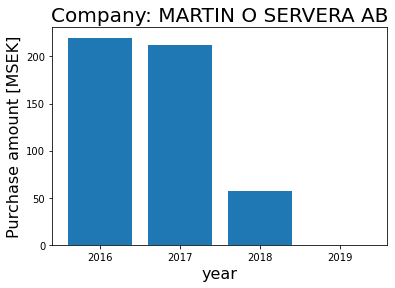

In [15]:
df_plot = df_supp_yy[df_supp_yy['leverantör'] == 'MARTIN O SERVERA AB']

# Get integer values only
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('year', fontsize = 16)

# Format the y-axis
scale_y_million = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y_million))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Purchase amount [MSEK]', fontsize = 16)

plt.bar(df_plot['year'], df_plot['belopp'])
plt.title('Company: MARTIN O SERVERA AB', fontsize = 20)

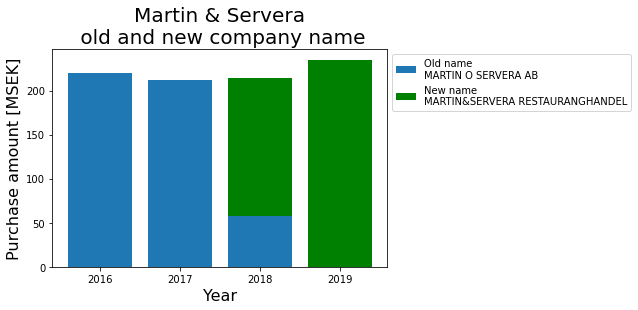

In [16]:
years = [2016,2017,2018,2019]

# Filter on the old and new company name
df_old = df_supp_yy[df_supp_yy['leverantör'] == 'MARTIN O SERVERA AB']
df_new = df_supp_yy[df_supp_yy['leverantör'] == 'MARTIN&SERVERA RESTAURANGHANDEL']

# Create a base of 0 and add old the company values. If no company value exist
# the value will be 0. This is done because new company only has values for 2018,2019
base = pd.Series([0,0,0,0], index = years)
value_old = base.add(df_old.set_index('year')['belopp'], fill_value = 0)
value_new = base.add(df_new.set_index('year')['belopp'], fill_value = 0)

# Get integer values only
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

p1 = plt.bar(years, value_old, label = 'Old name\nMARTIN O SERVERA AB')
p2 = plt.bar(years, value_new, bottom = value_old, color = 'green', label ='New name\nMARTIN&SERVERA RESTAURANGHANDEL')

# Format Y label for Million SEK
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y_million))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Purchase amount [MSEK]', fontsize = 16)

plt.xlabel('Year', fontsize = 16)
plt.title('Martin & Servera\n old and new company name', fontsize = 20)

plt.legend(bbox_to_anchor=(1,1))

#### Supplier analysis: CANOS VOB AB

How is it possible for companies to lose this amount of purchases from the city of Gothenburg?

* A quick google search results in articles about a company with some controversial business practices:
    * "They are earning millions on the refugee children" [Source](https://www.expressen.se/gt/de-tjanar-miljoner-pa-flyktingbarnen/)
    * "Company canos vob lied about the families suitability [Source](https://www.aftonbladet.se/nyheter/a/G1Le0l/foretaget-canos-vob-ljog-om-familjers-lamplighet)
    
In 2020 the company underwent bankruptcy [Source](https://www.allabolag.se/5569918864/canos-vob-ab)
    

> **What if:** Could companies which has some questionable business practices be found via use of webscraping and NLP? Could there be a list of controversial companies and how much the city of Gothenburg spends on those suppliers, which could be distributed to journalists for some possible interesting stories.



Text(0.5, 1.0, 'Canos VoB AB')

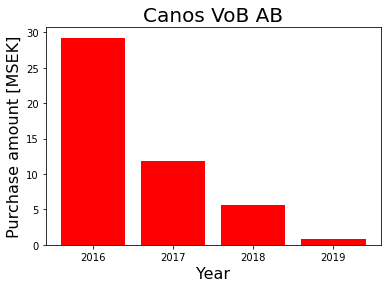

In [17]:
# Filter data for specific company
df_old = df_supp_yy[df_supp_yy['leverantör'] == 'CANOS VOB AB']
base = pd.Series([0,0,0,0], index = [2016,2017,2018,2019])
value_old = base.add(df_old.set_index('year')['belopp'], fill_value = 0)

# Get integer values only
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Format Y label for Million SEK
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y_million))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel('Purchase amount [MSEK]', fontsize = 16)

# Plot the graph
plt.bar(years, value_old, color = 'red')
plt.xlabel('Year', fontsize = 16)
plt.title('Canos VoB AB', fontsize = 20)

#### Bonus: Suppliers in the neighbourhood

Are there any suppliers in the neighbourhood which has significant trends?

Right now I live in Lindome, lets see if there are any noticeable suppliers in my area. 


In [18]:
#Find suppliers which has the text 'lindome' in there name
df_supp[df_supp['leverantör'].str.lower().str.match('.*lindome*')].sort_values('changes_wrt_mean', ascending = False)

,leverantör,increasing_mono,decreasing_mono,mean,total_diff,changes_wrt_mean
12867,LINDOME TRÄDGÅRD & FASTIGHET AB,False,False,"4,603,641","11,183,406",243
12865,LINDOME JBF AB,False,False,"14,901","1,511",10
12863,LINDOME FLYTTNINGSBYRÅ AB,False,False,"153,866","430,911",0
12864,LINDOME GYM OCH HÄLSA AKTIEBOLAG,False,False,"5,000",0,0
12866,LINDOME TRAFIKSKOLA,False,False,"5,500",0,0
12868,LINDOMES MULTISERVICE,False,False,"12,000",0,0
14882,MÅLERI1 I LINDOME AB,False,False,"12,496",0,0


The supplier **'LINDOME TRÄDGÅRD & FASTIGHET AB'** has a strong positive trend, with an increase of 243% of the purchases compared to its mean. 

Further analysis of the supplier:

In [19]:
df_supp_yy[df_supp_yy['leverantör'] == 'LINDOME TRÄDGÅRD & FASTIGHET AB']

,leverantör,year,belopp
27024,LINDOME TRÄDGÅRD & FASTIGHET AB,2016,"1,543,668"
27025,LINDOME TRÄDGÅRD & FASTIGHET AB,2017,"924,718"
27026,LINDOME TRÄDGÅRD & FASTIGHET AB,2018,"3,219,104"
27027,LINDOME TRÄDGÅRD & FASTIGHET AB,2019,"12,727,073"


12 MSEK in purchase could be a major amount for a small gardening and property maintenace company. Let's look online for their financial statements at https://www.guldbolag.se/5569055600/lindome-tradgard-fastighet-ab-kontaktuppgifter
In their financial statements for 2019 the total turnover for this company was close to 15MSEK, meaning that the Gothenburg purchase is accounting for around 80% of its business. 

>**What if:** Could external financial data be automatically fetched and compared with the purchase figures to understand what suppliers are most reliant on purchases from the Gothenburg City? Are there any common characteristic for these types of companies?




### Account analysis

**Processing the data**

Data needs to be grouped according to each account to view the amount that is spent on each account. 

In [20]:
#Grouping the data
df_account = df.groupby(['kontotext', 'konto'])['belopp'].sum().reset_index()

With a focus to analyze technical and IT type of purchases, the following accounts sound promising

* Tekniska konsulttjänster = Technical Consulting Services (7453)
* IT-program och licensavgifter = Software and IT-licenses (7433)
* IT konsulttjänster = IT Consulting Services (7452)

In [21]:
#Display data
df_account.sort_values('belopp', ascending=False).head(25)

,kontotext,konto,belopp
107,Köp av huvudverksamhet,4630,"33,122,244,032"
74,Husbyggnadsentreprenader,6175,"7,190,768,561"
11,Anläggningsentreprenad,6185,"6,665,024,547"
110,Lokalhyror,6011,"3,919,857,905"
123,"Pensionskostn, avgiftsbest ålderspension",5751,"2,743,086,646"
158,Upplupna övriga kostnader,2992,"2,281,143,846"
132,Reparationsentreprenad,6186,"1,653,020,683"
29,Bidrag föreningar företag kommuner mfl,4530,"1,563,639,614"
144,Tekniska konsulttjänster,7453,"1,283,280,681"
152,Transporter,7011,"1,158,855,479"


#### Technical Consulting Services (7453)

Looking at the major spendings for technical consulting services, there are a few suppliers which dominates this industry:

* **Norconsult**
* **Ramböll**
* **Sweco**
* **ÅF(Afry)**

Lets visualize them below:

In [22]:
#Filter data on account 7453 and group by supplier. Filter for top 10 suppliers based on purchase amount. 
df_7453 = df[df['konto'] == 7453].groupby('leverantör')['belopp'].agg(['sum', 'count']).sort_values('sum', ascending = False).head(10)
df_7453

,sum,count
leverantör,,
ÅF-INFRASTRUCTURE AB,"132,152,304",3984
STATENS HISTORISKA MUSEER,"91,531,290",210
RAMBÖLL SVERIGE AB,"84,872,976",2276
SWECO CIVIL AB,"64,992,285",1036
NORCONSULT AB,"58,082,488",2141
WSP SVERIGE AB,"51,498,694",1618
SWECO ENVIROMENT AB,"40,828,755",1100
ÅF-INFRASTRUKTUR AB,"39,148,117",1171
COWI AB,"29,203,125",1016


In [23]:
# Display yearly supplier data from the top purchase suppliers. 
df_supp_yy[df_supp_yy['leverantör'].isin(df_7453.index)].head(100)

,leverantör,year,belopp
3620,ATKINS SVERIGE AB,2016,"21,780,001"
3621,ATKINS SVERIGE AB,2017,"27,733,744"
3622,ATKINS SVERIGE AB,2018,"22,109,212"
3623,ATKINS SVERIGE AB,2019,"17,824,237"
8903,COWI AB,2016,"91,567,260"
8904,COWI AB,2017,"71,448,114"
8905,COWI AB,2018,"47,519,106"
8906,COWI AB,2019,"47,981,141"
32035,NORCONSULT AB,2016,"25,575,870"
32036,NORCONSULT AB,2017,"37,167,796"


Text(0.5, 1.0, 'Spending on technical consultancy')

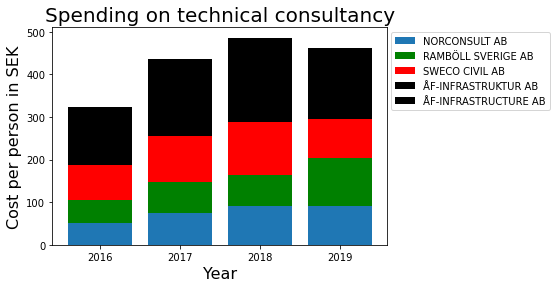

In [24]:
base = pd.Series([0,0,0,0], index = years)

#Filter data from the top suppliers
value_nor = df_supp_yy[df_supp_yy['leverantör'] == 'NORCONSULT AB']
value_ram = df_supp_yy[df_supp_yy['leverantör'] == 'RAMBÖLL SVERIGE AB']
value_swe = df_supp_yy[df_supp_yy['leverantör'] == 'SWECO CIVIL AB']
value_af1 = df_supp_yy[df_supp_yy['leverantör'] == 'ÅF-INFRASTRUKTUR AB']
value_af2 = df_supp_yy[df_supp_yy['leverantör'] == 'ÅF-INFRASTRUCTURE AB']

# Create a base of 0 and add old the company values. If no company value exist
# the value will be 0. This is done because some companies might not have values for all years.
value_nor = base.add(value_nor.set_index('year')['belopp'], fill_value = 0)
value_ram = base.add(value_ram.set_index('year')['belopp'], fill_value = 0)
value_swe = base.add(value_swe.set_index('year')['belopp'], fill_value = 0)
value_af1 = base.add(value_af1.set_index('year')['belopp'], fill_value = 0)
value_af2 = base.add(value_af2.set_index('year')['belopp'], fill_value = 0)


# Optional to divide by population to get 
pop = 500000 #Roughly the population size of gothenburg
value_nor = value_nor /pop
value_ram = value_ram /pop
value_swe = value_swe /pop
value_af1 = value_af1 /pop
value_af2 = value_af2 /pop

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot stacked barcharts
p1 = plt.bar(years, value_nor, label = 'NORCONSULT AB')
p2 = plt.bar(years, value_ram, bottom = value_nor, color = 'green', label = 'RAMBÖLL SVERIGE AB')
p3 = plt.bar(years, value_swe, bottom = value_nor + value_ram, color = 'red', label = 'SWECO CIVIL AB')
p4 = plt.bar(years, value_af1, bottom = value_nor + value_ram + value_swe, color = 'black', label = 'ÅF-INFRASTRUKTUR AB')
p5 = plt.bar(years, value_af2, bottom = value_nor + value_ram + value_swe + value_af1, color = 'black', label = 'ÅF-INFRASTRUCTURE AB')
plt.legend(bbox_to_anchor=(1, 0.5, 0.5, 0.5))

plt.ylabel('Cost per person in SEK', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.title('Spending on technical consultancy', fontsize = 20)


#### Software and IT-licenses (7433)

For the software and IT-licenses there are one giant among all suppliers, **ATEA**.

There are several articles about their [billion](https://computersweden.idg.se/2.2683/1.744826/atea-tar-hem-miljardavtal-med-goteborgs-stad) deals with the city of Gothenburg and also about competitors filing [complaints](https://spanaren.se/2017/10/17/konkurrent-polisanmaler-kommunens-affarer-med-dataforetaget-atea/) to the authorities about there way of selling to the city of Gothenburg. 



In [25]:
#Filter data on account 7433 and group by supplier. Filter for top 10 suppliers based on purchase amount. 
df_7433 = df[df['konto'] == 7433].groupby('leverantör')['belopp'].agg(['sum', 'count']).sort_values('sum', ascending = False)
df_7433.head(10)

,sum,count
leverantör,,
ATEA SVERIGE AB (FB),"428,189,226",1990
IBM GLOBAL FINANCING SWEDEN AB,"39,959,316",11
ADVANIA AB (FB),"18,689,237",15
PING PONG AB,"16,485,117",18
PLANIT SWEDEN AB,"15,125,179",29
MICROSOFT AB,"11,472,656",8
CGI,"10,526,174",75
IFS SVERIGE AB,"7,453,463",19
LANTMÄTERIET,"6,485,114",6


Text(0.5, 1.0, 'Software and IT-licenses purchases')

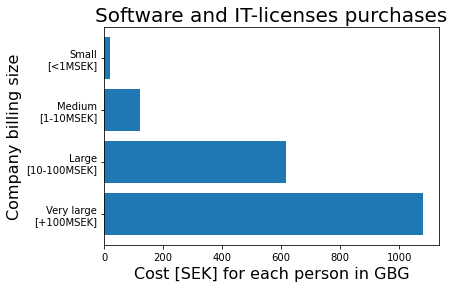

In [26]:
#Create labels and filter data accordingly
labels = ['Very large\n[+100MSEK]', 'Large\n[10-100MSEK]', 'Medium\n[1-10MSEK]', 'Small\n[<1MSEK]']
values = [df_7433[df_7433['sum'] > 10000000]['sum'].sum(),
          df_7433[(df_7433['sum'] < 100000000) & (df_7433['sum'] > 100000)]['sum'].sum(),
          df_7433[(df_7433['sum'] < 1000000) & (df_7433['sum'] > 10000)]['sum'].sum(),
          df_7433[df_7433['sum'] < 100000]['sum'].sum()
         ]

#Optional to divide by population
values = np.array(values)/pop

#Plot data
plt.barh(labels, values)
plt.xlabel('Cost [SEK] for each person in GBG', fontsize = 16)
plt.ylabel('Company billing size', fontsize = 16)
plt.title('Software and IT-licenses purchases', fontsize = 20)

#### IT-consulting services	7452

For IT-consulting services there are a more even playing fields, with a few major suppliers having the bulk of all the purchases from the city of Gothenburg

In [27]:
df_7452 = df[df['konto'] == 7452 ].groupby('leverantör')['belopp'].agg(['sum', 'count']).sort_values('sum', ascending = False)
df_7452.head(10)

,sum,count
leverantör,,
EWORK SCANDINAVIA AB,"297,733,111",5333
UNIBASE,"49,742,812",1300
ATEA SVERIGE AB (FB),"42,215,867",680
CGI,"30,525,832",406
SIGMA IT CONSULTING SWEDEN AB,"21,078,896",365
MAHOMEBEE CONSULTING AB,"18,175,698",258
PREERA AB,"15,579,073",112
MICROSOFT AB,"12,887,250",8
CONSID AB,"10,990,930",115


Text(0.5, 1.0, 'IT Consulting purchases')

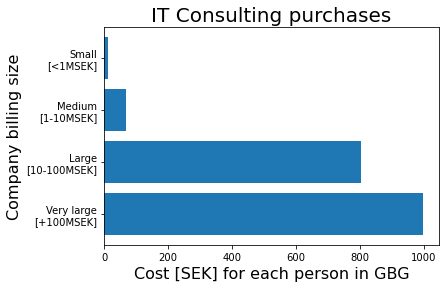

In [28]:
#Create labels and filter data accordingly
labels = ['Very large\n[+100MSEK]', 'Large\n[10-100MSEK]', 'Medium\n[1-10MSEK]', 'Small\n[<1MSEK]']
values = [df_7452[df_7452['sum'] > 10000000]['sum'].sum(),
          df_7452[(df_7452['sum'] < 100000000) & (df_7452['sum'] > 100000)]['sum'].sum(),
          df_7452[(df_7452['sum'] < 1000000) & (df_7452['sum'] > 10000)]['sum'].sum(),
          df_7452[df_7452['sum'] < 100000]['sum'].sum()
         ]

# Optional to divide by population
values = np.array(values)/pop

#Plot data
plt.barh(labels, values)
plt.xlabel('Cost [SEK] for each person in GBG', fontsize = 16)
plt.ylabel('Company billing size', fontsize = 16)
plt.title('IT Consulting purchases', fontsize = 20)

<a id='financial_data'></a>
## Mixing in Financial Data




<font size = 3>
    <i>
        
Exploration with financial data. Suppliers are having different levels of <b> dependency </b> on the purchases of the City of Gothenburg to survive. To find out, the open data can be augmented with the suppliers financial data to <b> compare invoicing with their total turnover </b>.
    </i>
    
* Combining financial data can result in additional insights, but there are also some limitations with this approach. City of Gothenburg purchasing and the suppliers turnover figures could be hard to compare if there are many invoices which are one 
accounting year for the city of Gothenburg but another one for the supplier. 
    
> **Q1:** Which companies are most reliant on the city of Gothenburg, in terms of the purchases in relation to their total turnover?    


### Finding external data


* There are many website servies which provides external financial data
* One of them is www.guldbolag.se, which provides many types of financial information such as the Income Statement and the Balance Sheet.
* Data could be fetched from this website in a organized way by scraping the data.
* Information about each companies financial statement is on: www.guldbolag.se/*organization_number*
* For this, the Request and Beautifulsoup library will be used

**Function to webscrape data**

Functions are built to be able to webscrape the data. 

Since there are possible errors, such as the organizationnumber might not exist at the site, these needs to be handled as well.

In [29]:
def check_error_html(html):
    '''Check if html content contain errors, which in case the function returns a string with error message
    If no error, returns False'''
    website_error_message = 'Ett fel har inträffat i Guldbolag!'
    error_text = ''
    
    #Check if 404 error, in which case the html content has a H2 header
    if html.find('h2') is not None:
        text = 'Website not found 404'
        return text
    
    #Else, check if the following website error message exit 
    elif html.find(('p')).text.strip() == website_error_message:
        text = 'Ett fel har inträffat i Guldbolag!'
        return text
    
    #If no error, return False
    else:
        return False

In [30]:
def webscrape_data(organization_number):
    '''Webscraping from site www.guldbolag.se
    Input is the companies organization number
    Function Will fetch the financial data from the 4 latest accounting years
    '''
    
    # Building up the url to fetch data from
    base_site = 'https://www.guldbolag.se/'
    parameter = str(organization_number)
    url = base_site + parameter

    # Request data
    data = requests.get(url)

    # Add to BeautifulSoup
    soup = BeautifulSoup(data.text, 'html.parser')

    # Before analyze, check if HTML content has an error message. 
    # If error message is found in parsed text, return a tuple with org_number and error message instead
    error_text = check_error_html(soup)
    if isinstance(error_text,str):
        return (organization_number, error_text)

    # Find the correct table with company figures
    table_figures = soup('table', {'id': 'bolagTable'})

    # Access all of the table rows <tr>
    table_rows = table_figures[0].find_all('tr')

    '''__Table structure__
    There are 11 rows in total.
    Row 0 is the table header, indicating what accounting year each column is refering to. 
    Row 1..10 is the table data.

    In each row:
        Element 0 is the ID/name of the metric
        Element 1..4 is the values, corresponding to the header accounting year.
    '''

    # Row 0 with table headers <th>
    table_headers = table_rows[0].find_all('th')

    # Row 1 with table data
    table_data = table_rows[1:]

    # Build a parsing function to get ID of metric as Key and values as a list
    def parse_rows(input_list, input_dict):
        '''Input a list and dictionary:
        Ouput will be the dictionary with an additional key, value pair.
        Element 0 in the input_list will be a key in the dictonary
        Following element will stored as list and be value in the dictionary'''
        v_list = []
        key = ''
        for count, value in enumerate(input_list):
            if count == 0:
                key = value.text.strip()
            else:
                v_list.append(value.text.strip())
        input_dict[key] = v_list
        return input_dict

    # Fill a dictionary with the company information
    result_dict = {}
    result_dict = parse_rows(table_headers, result_dict)  # Add headers data to the dictionary
    for row in table_data:  # Add table data to the dictionary
        row_data = row.find_all('td')
        result_dict = parse_rows(row_data, result_dict)

    # Convert dictionary into a dataframe
    df = pd.DataFrame.from_dict(result_dict, orient='index')  # Treat keys as index in Pandas Dataframe
    return df

**Determine what companies to fetch from**

Due to the large list of suppliers, a smaller amount can be selected if desired

In [31]:
# Select organisation number to query on.
list_orgnumbers = df['organisationsnummer'].unique()[:1000] #Select the first 1000 suppliers
list_orgnumbers = list_orgnumbers[~pd.isnull(list_orgnumbers)] #Verify no Nan values

**Scrape the data**

The task to scrape all the data is quite large, so a file is also available with the data already scraped (see comments in code below)

In [32]:
# Note that webscraping the full list of suppliers is a heavy computational task. 
# Full list was fetched on 2021-02-05 and stored as a pickle file
# If desireable to get new data, comment out the lines below were the pickle file is feched and 
# uncomment lines in the forloop

# Iterate over org_numbers. Add turnover figures from the scraped data.
dict_webscraped_data = {}
#for num in list_orgnumbers:
#    dict_webscraped_data[num] = webscrape_data(num)

# Fill can be accessed here:
pkl_file = open('dict_webscrape.pkl', 'rb')
dict_webscraped_data = pickle.load(pkl_file)
pkl_file.close()

#dict_webscrape = open('dict_webscrape.pkl', 'wb')
#pickle.dump(dict_webscraped_data, dict_webscrape)
#dict_webscrape.close()

**Appending the fetched financial data to the original dataframe**

Once the financial data has been fetched, there are various steps to append it in the proper format to the existing dataframe before being able to plot it.

One limitation has been made in the scenario where companies have split financial year, which means that it does not align with the calendar year and ends in some other month than December. These figures have not been included yet. 

In [33]:
def append_financial_data(webscraped_df, original_df, organization_number):
    '''Input as webscraped dataframe and the original dataframe as well as the organization number
    Will check that accouning year ends in december, and append financial data to the original dataframe'''
    for col in webscraped_df:
        
        # Check if the accounting year ends in december
        # By checking if final two digits is 12 the column header
        if webscraped_df[col][0][-2:] == '12':
            #Extract the year
            year = int(webscraped_df[col][0][:4])
            #Extract the turnover
            turnover = webscraped_df.loc['Nettoomsättning (tkr)', col]
            
            #Convert the string into a integer and multiply by 1000 since it's in thousands of SEK
            turnover = int(turnover.replace(' ', '')) * 1000
            
            #Assign the turnover for the given year
            original_df.loc[(organization_number,year),'financial_turnover'] = turnover

In [34]:
# Create a DataFrame filtered on the organization numbers that was fetched financial data. 
df_limited = (df.groupby(['organisationsnummer', 'year'])['belopp'].sum()).to_frame()
df_limited = df_limited[df_limited.index.get_level_values('organisationsnummer').isin(list_orgnumbers)]

In [35]:
# Augment the Dataframe with the turnover figures.
for org_number in list_orgnumbers:
    if not isinstance(dict_webscraped_data[org_number], tuple): # Check so the fetched data was not erroneous
        append_financial_data(dict_webscraped_data[org_number],df_limited,org_number)

In [36]:
# Calculate invoiced amount proportion of the suppliers total turnover
df_limited['proportion_of_turnover'] = np.array(df_limited['belopp'] / np.array(df_limited['financial_turnover']))
df_limited.sort_values('proportion_of_turnover', ascending=False).head(20)

belopp  financial_turnover  \
organisationsnummer year                                  
5569248841          2018    120,700                   0   
5561232108          2017 17,921,052                   0   
5590116314          2016     37,117                   0   
                    2018     57,800                   0   
                    2019     29,500                   0   
5566410048          2017     45,800                   0   
5561232108          2016 14,509,261                   0   
5560698119          2018  3,482,177                   0   
                    2019  1,956,458                   0   
5566437934          2019    583,666                   0   
5560698119          2017  3,134,210                   0   
5565397642          2016    110,195                   0   
5561232108          2018 14,048,400                   0   
5560698119          2016  4,092,703                   0   
5565397642          2018    123,375                   0   
                    2017    110,787                   0   
                    2019    188,713              83,000   
5561701581          2016 19,006,695          11,012,000   
5566437934          2016 24,110,558          16,029,000   
                    2018 15,879,815          11,232,000   

                          proportion_of_turnover  
organisationsnummer year                          
5569248841          2018                     inf  
5561232108          2017                     inf  
5590116314          2016                     inf  
                    2018                     inf  
                    2019                     inf  
5566410048          2017                     inf  
5561232108          2016                     inf  
5560698119          2018                     inf  
                    2019                     inf  
5566437934          2019                     inf  
5560698119          2017                     inf  
5565397642          2016                     inf  
5561232108          2018                     inf  
5560698119          2016                     inf  
5565397642          2018                     inf  
                    2017                     inf  
                    2019                       2  
5561701581          2016                       2  
5566437934          2016                       2  
                    2018                       1

**Visualizing data**

In the graph below there are many companies which are heavily reliant on the city of Gothenburg for its purchases, with several suppliers having more than 50% of their turnover from city of Gothenburg purchases. 


> **What if:** Could there be an possible insights into companies with high dependency from the city of Gothenburg. Since their possibilities to get new purchase contract from the city of Gothenburg is vital for their existence, are there differences in how they interact or communicate with the city of Gothenburg compared to other companies?



In [61]:
#Filter out data for only 2019 and having financial turnover > 0 and proporton of turnover <1. 
#Get top 10 companies
df_plot = df_limited[(df_limited.index.get_level_values('year') == 2019) & (df_limited['financial_turnover'] >0) & (df_limited['proportion_of_turnover'] <1)].sort_values('proportion_of_turnover', ascending=False).head(10)
# Based on the organization number, fetch the correct supplier name
# Note that because of mergers and other reasons, there can be a 1-to-many connection between org_number and supplier name
supplier_list = df[['organisationsnummer', 'leverantör']].drop_duplicates()
label_names = []
for org_number in df_plot.index.get_level_values(0):
    list_of_names = supplier_list['leverantör'][supplier_list['organisationsnummer'] == org_number]
    name_variants = ""
    for item in list_of_names:
        name_variants = name_variants + ' ||' + item
    label_names.append(name_variants)

Text(0.5, 1.0, 'Suppliers dependency on Gothenburg City \n (year 2019)')

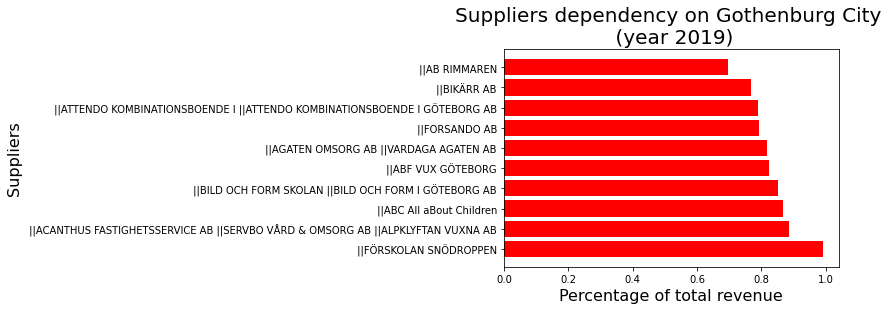

In [62]:
#Replace organization number with actual name for the suppliers
plt.barh(label_names, df_plot['proportion_of_turnover'], color = 'red')
plt.ylabel('Suppliers', fontsize = 16)
plt.xlabel('Percentage of total revenue', fontsize = 16)
plt.title('Suppliers dependency on Gothenburg City \n (year 2019)', fontsize = 20)